In [86]:
import warnings

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
plt.rcParams["figure.facecolor"] = "white"
plt.rcParams["axes.facecolor"] = "white"
plt.rcParams["font.family"] = "Arial"
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pandas as pd
import geopandas as gpd
import numpy as np
import rasterio
from shapely.geometry import *
from shapely.errors import ShapelyDeprecationWarning

from scrollstats import RASTER_PATHS, BendDataset, calculate_ridge_metrics

## Get Data

In [102]:
bend_id = "LBR_025"
bend_ds = BendDataset(bend_id)
transects = bend_ds.get_transects(proj=True)
ridges = bend_ds.get_ridges(proj=True)
packets= bend_ds.get_packets(proj=True)

dem = rasterio.open(RASTER_PATHS[bend_id]["dem"])
bin_raster = rasterio.open(RASTER_PATHS[bend_id]["bin"])


In [103]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore", ShapelyDeprecationWarning)
    rich_transects, itx = calculate_ridge_metrics(transects, bin_raster, dem, ridges)

itx = itx.loc[bend_id]

Started BDE
Started TDE for t_009
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started TDE for t_010
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started TDE for t_011
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started TDE for t_012
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started TDE for t_013
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started TDE for t_014
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started TDE for t_015
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started TDE for t_016
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started TDE for t_017
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RD

In [104]:
itx.head()

start_distances  transect_position  metric_confidence  \
transect_id ridge_id                                                          
t_009       r_002          185.679231                  4                  4   
            r_003          247.186196                  5                  4   
            r_007          334.035335                  6                  4   
            r_018          114.298928                  1                  1   
            r_019            0.000000                  0                  1   

                                              relative_vertex_distances  \
transect_id ridge_id                                                      
t_009       r_002     [0.4251412010392586, 0.5659708704817383, 0.764...   
            r_003     [0.5659708704817383, 0.764825353200405, 0.8918...   
            r_007     [0.764825353200405, 0.8918286694627616, 1.0000...   
            r_018     [0.26170500119995826, 0.3078529440844938, 0.32...   
            r_019        [0.0, 0.26170500119995826, 0.3078529440844938]   

                       vertex_indices  \
transect_id ridge_id                    
t_009       r_002     [185, 247, 333]   
            r_003     [247, 333, 389]   
            r_007     [333, 389, 436]   
            r_018     [114, 134, 144]   
            r_019       [0, 114, 134]   

                                                             dem_signal  \
transect_id ridge_id                                                      
t_009       r_002     [67.69890594482422, 67.68925476074219, 67.6816...   
            r_003     [66.97003173828125, 66.94657897949219, 66.8770...   
            r_007     [66.9379653930664, 66.9395980834961, 67.164581...   
            r_018     [67.0978012084961, 67.08560180664062, 67.16011...   
            r_019     [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   

                                                   dem_signal_selection  \
transect_id ridge_id                                                      
t_009       r_002     [67.69890594482422, 67.68925476074219, 67.6816...   
            r_003     [66.97003173828125, 66.94657897949219, 66.8770...   
            r_007     [66.9379653930664, 66.9395980834961, 67.164581...   
            r_018     [67.0978012084961, 67.08560180664062, 67.16011...   
            r_019     [65.37324523925781, 65.60702514648438, 65.7352...   

                                                             bin_signal  \
transect_id ridge_id                                                      
t_009       r_002     [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...   
            r_003     [1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...   
            r_007     [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...   
            r_018     [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...   
            r_019     [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   

                                                              bool_mask  \
transect_id ridge_id                                                      
t_009       r_002     [True, True, True, True, True, True, True, Tru...   
            r_003     [True, True, True, True, True, False, False, F...   
            r_007     [True, True, True, True, True, True, True, Tru...   
            r_018     [True, True, True, True, True, True, True, Tru...   
            r_019     [True, True, True, True, True, True, True, Tru...   

                      pre_mig_dist  ...  pre_mig_time  post_mig_time  \
transect_id ridge_id                ...                                
t_009       r_002        86.849140  ...           NaN            NaN   
            r_003        55.468343  ...           NaN            NaN   
            r_007        47.243526  ...           NaN            NaN   
            r_018         9.490952  ...           NaN            NaN   
            r_019        20.154985  ...           NaN            NaN   

                      pre_mig_rate  post_mig_

# Plot with Histograms

In [105]:
def agg_by_x(itx, col, num_bins=20, agg_func="mean"):
    """Aggregate the values at each itx to a given number of columns."""

    # Get bounds of the itx dataframe
    minx, miny, maxx, maxy = itx.total_bounds

    # Get x coords of the bins
    bin_xcoords = np.linspace(minx, maxx, num_bins)

    # Create array of bounding boxes for x axis
    geoms = [box(x1, miny, x2, maxy) for x1, x2 in zip(bin_xcoords[:-1], bin_xcoords[1:])]

    xbins = gpd.GeoDataFrame({"geometry":geoms}, crs = itx.crs)
    agg_values = xbins.sjoin(itx)[col].groupby(level=0).agg(agg_func)

    # Join agg values back onto geometries
    xbin_agg = xbins.join(agg_values)
    
    return xbin_agg

In [106]:
def agg_by_y(itx, col, num_bins=20, agg_func="mean"):
    """Aggregate the values at each itx to a given number of columns."""

    # Get bounds of the itx dataframe
    minx, miny, maxx, maxy = itx.total_bounds

    # Get y coords of the bins
    bin_ycoords = np.linspace(miny, maxy, num_bins)

    # Create array of bounding boxes for y axis
    geoms = [box(minx, y1, maxx, y2) for y1, y2 in zip(bin_ycoords[:-1], bin_ycoords[1:])]

    ybins = gpd.GeoDataFrame({"geometry":geoms}, crs = itx.crs)
    agg_values = ybins.sjoin(itx)[col].groupby(level=0).agg(agg_func)

    # Join agg values back onto geometries
    ybin_agg = ybins.join(agg_values)
    
    return ybin_agg

In [107]:
# fig = plt.figure(figsize=(5,4))
# gs = GridSpec(4,5, figure=fig)

# # Main Itx Plot
# vmin = 0
# vmax = itx["ridge_amp"].max()

# ## Create Colorbar
# ax1 = fig.add_subplot(gs[1:, :4])
# divider = make_axes_locatable(ax1)
# cax = divider.append_axes("left", size="5%", pad=0.1, aspect=2)

# ## Plot itx and ridges
# itx.plot(ax=ax1, column="ridge_amp", markersize="ridge_width", vmin=vmin, vmax=vmax, legend=True, cax=cax)
# ridges.plot(ax=ax1, color="k", ls="--", lw=0.5, zorder=0)

# min_max = [vmin, vmax]
# cax.set_yticks(min_max, labels = np.round(min_max, 1))
# cax.set_ylabel("Amplitude [m]")

# cax.yaxis.set_ticks_position('left')
# cax.yaxis.set_label_position('left')

# ax1.set_axis_off()

# # Top hist
# ax2 = fig.add_subplot(gs[0, :4])
# xbins = agg_by_x(itx, "ridge_amp", 20, "mean")
# xbins["ridge_amp"].T.plot(kind="bar", ax=ax2, width=0.8, color="mediumseagreen")
# ax2.set_xticks([])
# ax2.set_yticklabels(["0m", "2m"])
# ax2.set_xlim(-3.5, 21.5)
# ax2.spines["top"].set_color(None)
# ax2.spines["right"].set_color(None)


# # Right Hist
# ax3 = fig.add_subplot(gs[1:, 4])
# ybins = agg_by_y(itx, "ridge_amp", 20, "mean")
# ybins["ridge_amp"].plot(kind="barh", ax=ax3, width=0.8, color="mediumseagreen")
# ax3.set_yticks([])
# ax3.set_xticklabels(["0m", "2m"])
# ax3.set_ylim(-4.5, 24.8)
# ax3.spines["top"].set_color(None)
# ax3.spines["right"].set_color(None)

# # Top box
# ax4 = fig.add_subplot(gs[0, -1])
# ax4.text(0.5, 0.5, "Mean\nAmplitude", horizontalalignment="center", verticalalignment="center")
# ax4.set_xticks([])
# ax4.set_yticks([])
# ax4.set_axis_off()

# # Add x and x bins as a grid
# xbins.boundary.plot(ax=ax1, color='grey', lw=0.2, alpha=0.5, zorder=0)
# ybins.boundary.plot(ax=ax1, color='grey', lw=0.2, alpha=0.5, zorder=0)

# # plt.tight_layout()
# plt.subplots_adjust(wspace=0.1, hspace=0.1)
# # plt.savefig("/Users/avan/FLUD/BrazosScrolls/figures/RidgeAmplitudeJointPlot_colorbar.png", dpi=300)


## Create box plots of ridge metrics

In [108]:
ridge_metrics = itx[["ridge_amp", "ridge_width", "pre_mig_dist"]]
ridge_metrics.columns = ridge_metrics.columns.rename("metrics")
ridge_metrics

metrics               ridge_amp  ridge_width  pre_mig_dist
transect_id ridge_id                                      
t_009       r_002      0.778679         22.0     86.849140
            r_003      1.298214         18.0     55.468343
            r_007      1.585457         29.0     47.243526
            r_018      1.861023          NaN      9.490952
            r_019      3.155273          NaN     20.154985
...                         ...          ...           ...
t_047       r_012      0.662466         20.0     81.149474
            r_013      0.716354         13.0     39.219145
t_048       r_012      0.722620         12.0     65.307459
            r_013      1.100231         22.0     47.815527
t_049       r_013      0.430981         15.0     69.967953

[245 rows x 3 columns]

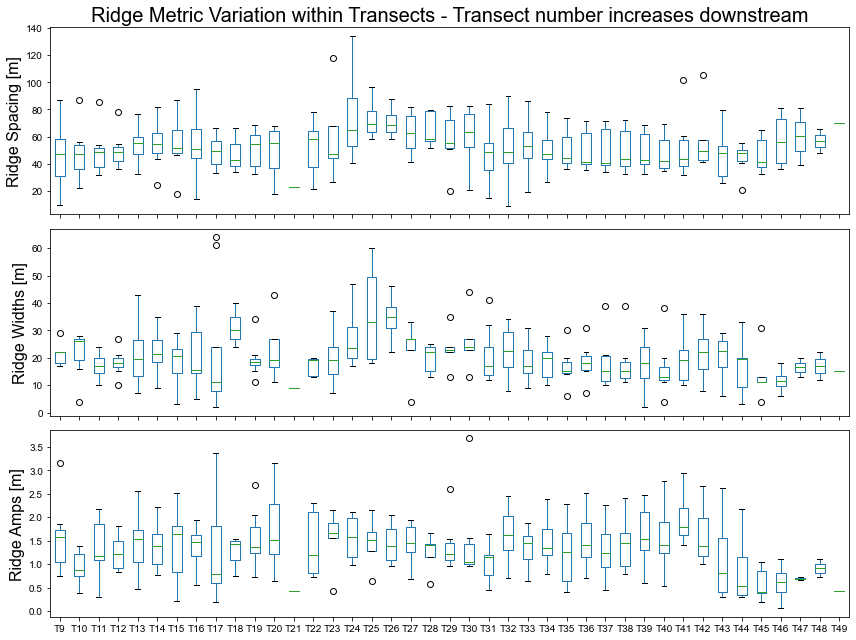

In [109]:
ridge_metrics_per_transect = ridge_metrics.unstack(level=0)

amps_per_transect = ridge_metrics_per_transect["ridge_amp"]
widths_per_transect = ridge_metrics_per_transect["ridge_width"]
spacing_per_transect = ridge_metrics_per_transect["pre_mig_dist"]

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 9))

ax1 = spacing_per_transect.boxplot(ax=ax1, grid=False)
ax2 = widths_per_transect.boxplot(ax=ax2, grid=False)
ax3 = amps_per_transect.boxplot(ax=ax3, grid=False)

# Set tick labels
ax1.set_xticklabels([])
ax2.set_xticklabels([])
ax3.set_xticklabels(spacing_per_transect.columns.str.replace("t_0*", "T", regex=True))

# Set y labels
ax1.set_ylabel("Ridge Spacing [m]", size=16)
ax2.set_ylabel("Ridge Widths [m]", size=16)
ax3.set_ylabel("Ridge Amps [m]", size=16)

# ax1.plot([0, 36], [120,120], color="r")

ax1.set_title("Ridge Metric Variation within Transects - Transect number increases downstream", size=20, horizontalalignment="center")
plt.tight_layout()
plt.savefig(f"RidgeMetrics_Boxplot_Transect_{bend_id}.png", dpi=300)


<AxesSubplot:xlabel='ridge_amp', ylabel='ridge_width'>

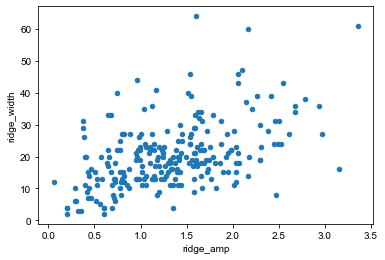

In [110]:
ridge_metrics.plot(x="ridge_amp", y="ridge_width", kind="scatter")

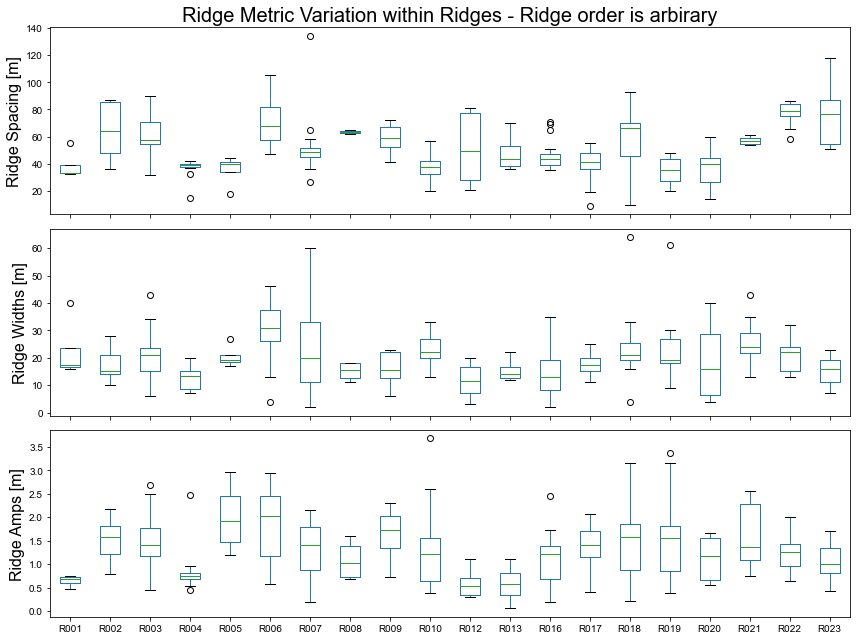

In [111]:
ridge_metrics_per_ridge = ridge_metrics.unstack()

amps_per_ridge = ridge_metrics_per_ridge["ridge_amp"]
widths_per_ridge = ridge_metrics_per_ridge["ridge_width"]
spacing_per_ridge = ridge_metrics_per_ridge["pre_mig_dist"]

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 9))

ax1 = spacing_per_ridge.boxplot(ax=ax1, grid=False)
ax2 = widths_per_ridge.boxplot(ax=ax2, grid=False)
ax3 = amps_per_ridge.boxplot(ax=ax3, grid=False)

# Set tick labels
ax1.set_xticklabels([])
ax2.set_xticklabels([])
ax3.set_xticklabels(spacing_per_ridge.columns.str.replace("r_*", "R", regex=True))

# Set y labels
ax1.set_ylabel("Ridge Spacing [m]", size=16)
ax2.set_ylabel("Ridge Widths [m]", size=16)
ax3.set_ylabel("Ridge Amps [m]", size=16)

ax1.set_title("Ridge Metric Variation within Ridges - Ridge order is arbirary", size=20, horizontalalignment="center")
plt.tight_layout()
plt.savefig(f"RidgeMetrics_Boxplot_Ridge_{bend_id}.png", dpi=300)

# Create plot with metrics at the ridge, transect and packet aggregate scales


In [112]:
def normalize_vals(x):
    """Normalize the values within an array x between 0 and 1 """
    norm = (x - x.min())/(x.max()-x.min())
    return norm

In [113]:
# Aggregate to the ridge scale
ridge_agg = itx.groupby(level=-1).agg("median")
ridge_agg["ridge_amp_norm"] = normalize_vals(ridge_agg["ridge_amp"])
ridge_agg = ridge_agg.join(ridges.set_index("ridge_id").geometry)


In [114]:
# Aggregate to the transect scale
trans_agg = itx.groupby(level=0).agg("median")
trans_agg["ridge_amp_norm"] = normalize_vals(trans_agg["ridge_amp"])
trans_agg = trans_agg.join(transects.set_index("transect_id").geometry)

In [115]:
# Normalize within the packets

# Spatial join packet id onto itx points
itx_packets = itx.sjoin(packets.drop("bend_id", axis=1))
itx_packets = itx_packets.reset_index().set_index(["packet_id", "transect_id", "ridge_id"])

# Normalize amplitude and width within packet bounds
packet_norm = itx_packets[["ridge_amp", "ridge_width"]].groupby(level=0).apply(normalize_vals)

# Join back the geometry anc recast to GDF
packet_norm = gpd.GeoDataFrame(packet_norm.join(itx_packets.geometry, how="left"))
packet_norm.head()


ridge_amp  ridge_width  \
packet_id transect_id ridge_id                           
p_04      t_009       r_002      0.182485     0.300000   
                      r_018      0.525356          NaN   
                      r_019      0.935356          NaN   
                      r_020      0.433118     0.216667   
                      r_021      0.172256     0.300000   

                                                      geometry  
packet_id transect_id ridge_id                                  
p_04      t_009       r_002     POINT (839158.987 4310982.258)  
                      r_018     POINT (839089.497 4310894.231)  
                      r_019     POINT (839069.856 4310889.707)  
                      r_020     POINT (839097.484 4310899.358)  
                      r_021     POINT (839121.590 4310933.426)

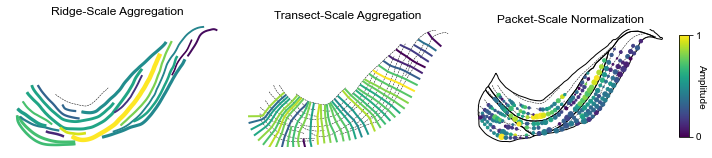

In [116]:
def adjust_ax_lim(min, max, perc):
    dist = max - min
    buff = dist*perc
    return(min-buff, max+buff)

# Make plot
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 4))

text_coords = (839355, 4311246)

# Ridge plot
ridge_agg.plot(ax=ax1, column="ridge_amp_norm",linewidth=ridge_agg["ridge_width"]/7)
ridges.plot(ax=ax1, color="k", ls="--", lw=0.5, zorder=0)

# ax1.text(*text_coords, "Ridge-Scale\nAggregation")
ax1.set_title("Ridge-Scale Aggregation")
ax1.set_ylim(*adjust_ax_lim(*ridges.total_bounds[1::2], 0.05))
ax1.set_axis_off()

# Transect Plot
trans_agg.plot(ax=ax2, column="ridge_amp_norm", linewidth=2)
ridges.plot(ax=ax2, color="k", ls="--", lw=0.5, zorder=0)

# ax2.text(*text_coords, "Transect-Scale\nAggregation")
ax2.set_title("Transect-Scale Aggregation")
ax2.set_axis_off()
ax2.set_ylim(*adjust_ax_lim(*ridges.total_bounds[1::2], 0.05))

# Packet Plot
divider = make_axes_locatable(ax3)
cax = divider.append_axes("right", size="5%", pad=0.1, aspect=10)

packet_norm.plot(ax=ax3, column="ridge_amp", markersize=packet_norm["ridge_width"]*30, legend=True, cax=cax)
ridges.plot(ax=ax3, color="k", ls="--", lw=0.5, zorder=0)
packets.boundary.plot(ax=ax3, color="k", lw=1, zorder=0)

min_max = [0,1]
cax.set_yticks(min_max, labels = np.round(min_max, 1))
cax.set_ylabel("Amplitude", rotation=270)

# ax3.text(*text_coords, "Packet-Scale\nNormalization")
ax3.set_title("Packet-Scale Normalization")
ax3.set_axis_off()
ax3.set_ylim(*adjust_ax_lim(*ridges.total_bounds[1::2], 0.05))

# plt.suptitle("Aggregated Ridge Metrics", size=20)
plt.tight_layout()


plt.savefig(f"MultiScaleMetrics_{bend_id}.png", dpi=300)

In [118]:
itx["ridge_amp"].sort_values()

transect_id  ridge_id
t_046        r_013       0.057140
t_045        r_016       0.198799
t_017        r_007       0.201878
t_015        r_018       0.202625
t_044        r_016       0.288326
                           ...   
t_020        r_005       2.964149
             r_018       3.152943
t_009        r_019       3.155273
t_017        r_019       3.359337
t_030        r_010       3.680397
Name: ridge_amp, Length: 245, dtype: float64

<AxesSubplot:xlabel='ridge_amp', ylabel='ridge_width'>

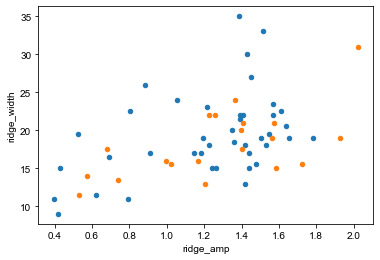

In [161]:
ax = trans_agg.plot(kind="scatter", x="ridge_amp", y="ridge_width")
ridge_agg.plot(kind="scatter", x="ridge_amp", y="ridge_width", color="tab:orange", ax=ax)

<AxesSubplot:>

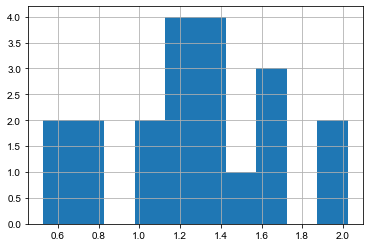

In [139]:
ridge_agg["ridge_amp"].hist()

In [170]:
trans_amp_range = trans_agg["ridge_amp"].max() - trans_agg["ridge_amp"].min()
ridge_amp_range = ridge_agg["ridge_amp"].max() - ridge_agg["ridge_amp"].min()

trans_width_range = trans_agg["ridge_width"].max() - trans_agg["ridge_width"].min()
ridge_width_range = ridge_agg["ridge_width"].max() - ridge_agg["ridge_width"].min()

print(f"Range for transect median amplitude: {trans_amp_range}")
print(f"Range for ridge median amplitude: {ridge_amp_range}")
print("\n")
print(f"Range for transect median width: {trans_width_range}")
print(f"Range for ridge median amplitude: {ridge_width_range}")

Range for transect median amplitude: 1.3851680755615234
Range for ridge median amplitude: 1.4942941665649414


Range for transect median width: 26.0
Range for ridge median amplitude: 19.5


<AxesSubplot:>

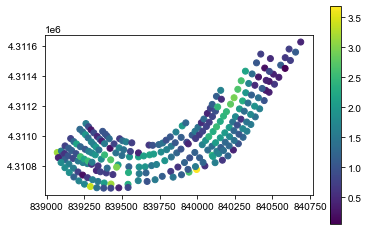

In [125]:
itx.plot(column="ridge_amp", legend=True)

In [144]:
def calc_iqr(x):
    q25, q75 = np.quantile(x, [0.25, 0.75])
    iqr = q75 - q25
    return iqr

(array([3., 1., 3., 9., 6., 8., 5., 2., 2., 2.]),
 array([0.        , 0.12995577, 0.25991154, 0.38986731, 0.51982307,
        0.64977884, 0.77973461, 0.90969038, 1.03964615, 1.16960192,
        1.29955769]),
 <BarContainer object of 10 artists>)

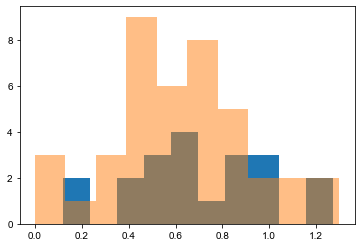

In [156]:
ridge_iqr = ridge_metrics["ridge_amp"].groupby(level=-1).apply(calc_iqr)
trans_iqr = ridge_metrics["ridge_amp"].groupby(level=0).apply(calc_iqr)

fig, ax = plt.subplots(1, 1)

ax.hist(ridge_iqr.values)
ax.hist(trans_iqr.values, alpha=0.5)